In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats
from scipy import constants as con
import pandas as pd
from scipy.interpolate import interp1d
from time import sleep
import pickle

import sys
import os
'''from lightsource_tech import Monochromator, list_monochromator_ports, list_monochromator_calibrations

sys.path.insert(0, "/home/canada/munich_pmt_calibration_system/QE_setup/")
from devices.Picoamp_6485 import Picoamp_6485_0
from devices.Picoamp_6485 import Picoamp_6485_1
from devices.Picoamp import Picoamp
from devices.PSU import PSU0,PSU2
from devices.uBase_int import uBase_int'''

from pathlib import Path
repo_root = Path.cwd()
save_dir_path = repo_root / "pde_measurement.pkl"
print(save_dir_path)

/home/josef/Documents/Master/Masterarbeit/OMCU_masters_project/pde_measurement.pkl


In [5]:
my_mono = Monochromator()   # initializes with the Calibration directory that is in the current path                                                
my_mono.connect()           # connect to serial port                                                                                                
my_mono.shutter_pos = 0     # 0: closed, 1: open
my_mono.wavelength = 550

Reading tuning ['"B', ' 100', ' no_filter:SET_POS_1:213', ' LP_345nm:SET_POS_2:277', ' LP_645nm:SET_POS_3:178', ' LP_1000nm:SET_POS_4:143', ' void_1:SET_POS_5:213"']
filter name ['no_filter', 'LP_345nm', 'LP_645nm', 'LP_1000nm', 'void_1']
1
{0: {'label': 'Grating_600_500_(0050)', 'enabled': 'TRUE', 'lines': 600, 'blaze': 500.0, 'min_wavelength': 200.0, 'max_wavelength': 2000.0, 'switch_wavelength': 9999.0, 'default_wavelength': 500.0, 'increment': 0.1, 'interpolation': 'linear', 'tolerance': 0.2, 'zero_order_pos': 366616}}
What is the value 0
Hello from the other side


In [18]:
uBase_int.Instance().SetVoltage(voltage=90,channel=0)

Connected to Raspberry Pi at 10.152.8.226:12346


('90.0,00560069 41305019 20363539', '2')

In [4]:
#scan through wavelengths for manual check
wavelength=np.arange(300,701,20)
my_mono.shutter_pos = 1
for wl in wavelength:
    my_mono.wavelength=wl
    print(wl)
    sleep(5)

What is the value 1
Hello from the other side
300
320
340
360
380
400
420
440
460
480
500
520
540


KeyboardInterrupt: 

In [16]:
print(np.mean(Picoamp_6485_1.Instance().read(2)))
print(np.mean(Picoamp_6485_0.Instance().read(2)))

-8.5992965e-13
-1.993865e-09


In [ ]:
#PDE using PD 
wavelength = np.arange(300, 701, 10)

pd_c=[]
pmt=[]
pmt_std=[]

my_mono.shutter_pos = 1
for wl in wavelength:
    my_mono.wavelength = wl
    #pd_c.append(np.mean(Picoamp_6485_1.Instance().read(2)))
    current=Picoamp_6485_0.Instance().read(5)
    pmt.append(np.mean(current))
    pmt_std.append(np.std(current))
    print(wl,":",pmt[-1]) #,pd_c[-1]

my_mono.shutter_pos = 0

What is the value 1
Hello from the other side
300 : -7.353516e-08
310 : -1.6102713999999998e-07
320 : -3.3609896e-07
330 : -6.5835332e-07
340 : -1.1397542e-06
350 : -1.7442312e-06
360 : -2.1266266000000005e-06
370 : -2.7655059999999998e-06
380 : -3.8438654000000004e-06
390 : -5.5978598e-06
400 : -7.789428e-06
410 : -9.6153654e-06
420 : -1.0438286e-05
430 : -1.0621195999999998e-05
440 : -1.1865984e-05
450 : -1.3667576e-05
460 : -1.4934352000000001e-05
470 : -1.5121589999999999e-05
480 : -1.1440804e-05
490 : -9.2499606e-06
500 : -7.2657236e-06
510 : -5.5814372e-06
520 : -4.011135e-06
530 : -2.610531e-06
540 : -1.6456328e-06
550 : -1.0757122000000001e-06
560 : -6.5158506e-07
570 : -3.7719364000000003e-07
580 : -2.3774906e-07
590 : -1.6550958000000002e-07
600 : -1.334019e-07
610 : -1.0868998000000001e-07
620 : -8.598088e-08
630 : -5.8091072000000004e-08
640 : -3.52936e-08
650 : -2.273904e-08
660 : -1.4504568e-08
670 : -1.280297e-08
680 : -1.1996486e-08
690 : -1.1111608e-08
700 : -8.0204486

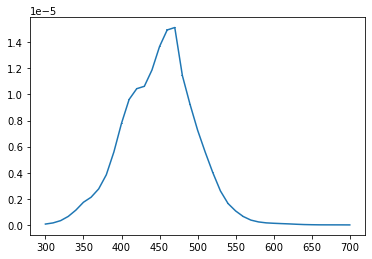

In [25]:
#plot the data before saving
plt.errorbar(wavelength,-np.array(pmt),yerr=pmt_std)
#plt.yscale("log")
plt.show()

In [23]:
#save data
if os.path.exists(save_dir_path):
    with open(save_dir_path, "rb") as f:
        measurements = pickle.load(f)
else:
    measurements = {}

#measurements["PD_ref"]=pd_c
measurements["new_PMT+splitter"]=pmt
measurements["new_PMT+splitter_std"]=pmt_std

with open(save_dir_path, "wb") as f:
    pickle.dump(measurements, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved in file'")

Saved in file'


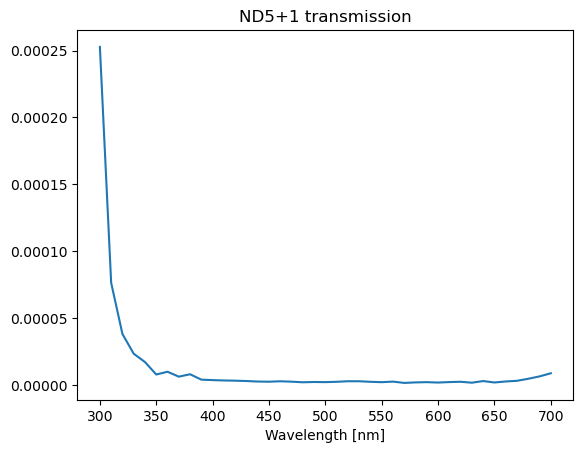

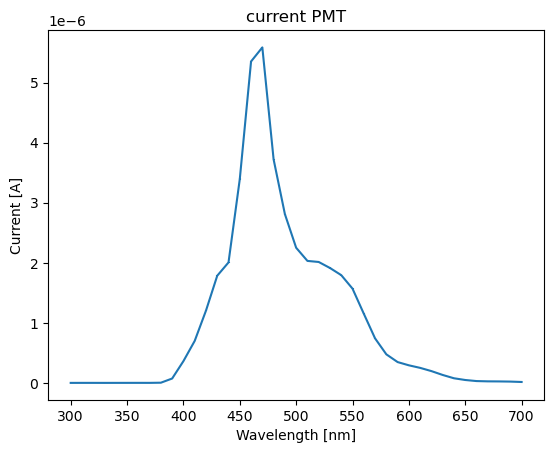

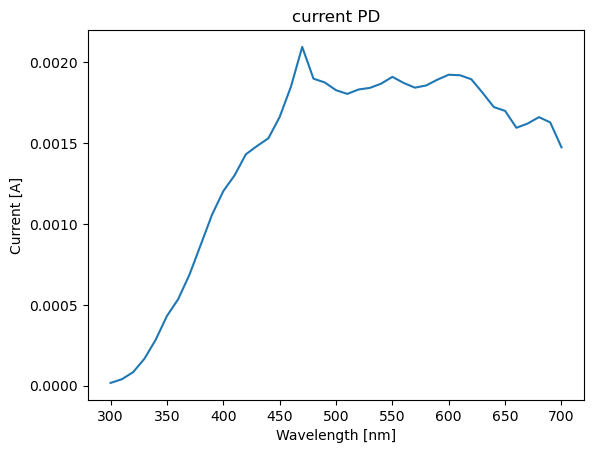

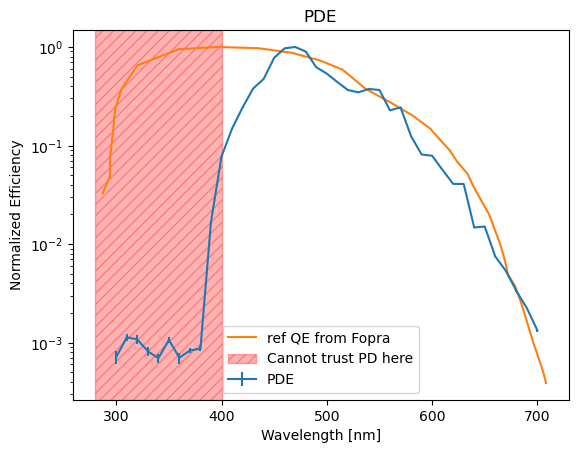

In [15]:
#PDE using ref PMT and 5+1 ND filter
#load data

with open(save_dir_path, "rb") as file:
    loaded_data = pickle.load(file)

wavelength = np.arange(300, 701, 10)

ref_qe=np.array(pd.read_csv("ref_QE.txt", sep=";", header=None)).transpose()

R=np.array(pd.read_csv('nist.csv', skiprows=5, encoding='latin1',delimiter=";")).transpose()
R=np.interp(wavelength, R[0],R[1])

ref_pmt=-np.array(loaded_data["new_PMT"])
ref_pmt_splitter=-np.array(loaded_data["new_PMT+splitter"])
ref_pd=-np.array(loaded_data["PD_ref"])
nd_signal=-np.array(loaded_data["ND5+1"])

pmt_std=np.array(loaded_data["new_PMT_std"])
#calculate transmission
t=nd_signal/ref_pd

#calculate PDE
pde=ref_pmt*R/(ref_pd*wavelength*t)
pde_max=np.max(pde)
pde/=pde_max

pde_splitter=ref_pmt_splitter*R/(ref_pd*wavelength*t)
pde_splitter_max=np.max(pde_splitter)
pde_splitter/=pde_splitter_max
#make plots
plt.plot(wavelength,t)
plt.title("ND5+1 transmission")
plt.xlabel("Wavelength [nm]")
plt.show()

plt.errorbar(wavelength, ref_pmt, yerr=pmt_std)
#plt.plot(wavelength,ref_pmt_splitter)
plt.title("current PMT")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Current [A]")
plt.show()

plt.plot(wavelength,ref_pd/R*wavelength)
plt.title("current PD")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Current [A]")
plt.show()


pde_err=pde*pmt_std / np.abs(ref_pmt)
plt.errorbar(wavelength, pde, yerr=pde_err, label="PDE")
#plt.plot(wavelength,pde_splitter,label="PDE w/ splitter")
plt.plot(ref_qe[0],ref_qe[1]/np.max(ref_qe[1]),label="ref QE from Fopra")
plt.axvspan(280, 400, color='red', alpha=0.3, hatch='///', label='Cannot trust PD here')
plt.title("PDE")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Normalized Efficiency")
plt.yscale("log") 
plt.legend()
plt.show()




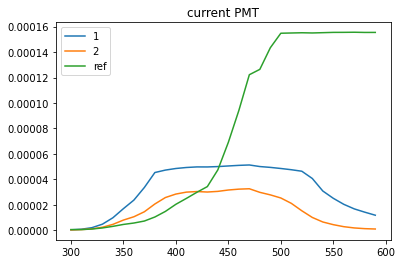

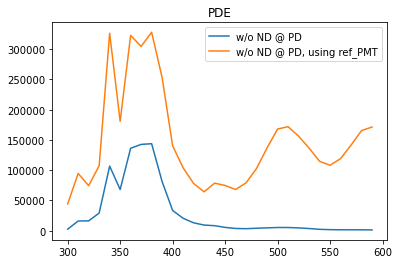

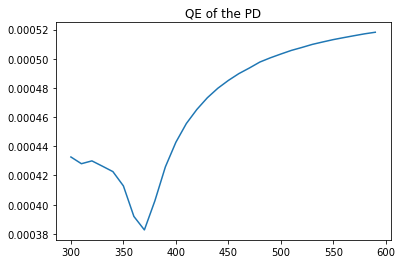

In [53]:
#calculate ND transmission
save_dir_path="/home/canada/munich_pmt_calibration_system/OMCU_masters_project/pde_measurement.pkl"
wavelength = np.arange(300, 600, 10)
with open(save_dir_path, "rb") as file:
    loaded_data = pickle.load(file)

current_pd=-np.array(loaded_data["PD"])
pmt=-np.array(loaded_data["PMT"])
pd2=-np.array(loaded_data["PD2"])
pmt2=-np.array(loaded_data["PMT2"])
ref_pmt=-np.array(loaded_data["ref_PMT"])

R=np.array(pd.read_csv('nist.csv', skiprows=5, encoding='latin1',delimiter=";")).transpose()
R=np.interp(wavelength, R[0],R[1])
data=-np.array(pd.read_csv("ND_filter_test.csv",header=None))
t=data[2]/data[0]
t2=data[1]/data[0]

#plot

plt.plot(wavelength,pmt,label="1")
plt.plot(wavelength,pmt2,label="2")
plt.plot(wavelength,ref_pmt,label="ref")
plt.title("current PMT")
plt.legend()
plt.show()
plt.plot(wavelength,pmt*R/(current_pd*wavelength*t),label="w/o ND @ PD")
#plt.plot(wavelength,pmt2*R*t2/(pd2*wavelength*t)*10,label="w/ ND @ PD")
#plt.plot(wavelength,pmt2*R/(pd2*wavelength)*10,linestyle="--",label="w/ ND @ PD - but no filter ratio")
plt.plot(wavelength,ref_pmt*R/(current_pd*wavelength*t)*10,label="w/o ND @ PD, using ref_PMT")
plt.title("PDE")
#plt.yscale("log") 
plt.legend()
plt.show()
plt.plot(wavelength,R/wavelength)
plt.title("QE of the PD")
plt.show()

Reading tuning ['"B', ' 100', ' no_filter:SET_POS_1:213', ' LP_345nm:SET_POS_2:277', ' LP_645nm:SET_POS_3:178', ' LP_1000nm:SET_POS_4:143', ' void_1:SET_POS_5:213"']
filter name ['no_filter', 'LP_345nm', 'LP_645nm', 'LP_1000nm', 'void_1']
1
{0: {'label': 'Grating_600_500_(0050)', 'enabled': 'TRUE', 'lines': 600, 'blaze': 500.0, 'min_wavelength': 200.0, 'max_wavelength': 2000.0, 'switch_wavelength': 9999.0, 'default_wavelength': 500.0, 'increment': 0.1, 'interpolation': 'linear', 'tolerance': 0.2, 'zero_order_pos': 366616}}
What is the value 0
Hello from the other side
What is the value 1
Hello from the other side
57600
300 :  -5.291674e-08
310 :  -1.0385444999999999e-07
320 :  -1.848589e-07
330 :  -3.0079945e-07
340 :  -4.4118035e-07
350 :  -5.821698e-07
360 :  -6.423224e-07
370 :  -7.6753305e-07
380 :  -9.9545935e-07
390 :  -1.2449925e-06
400 :  -1.4558215e-06
410 :  -1.5998665e-06
420 :  -1.7767825000000001e-06
430 :  -1.84837e-06
440 :  -1.9196145e-06
450 :  -2.095974e-06
460 :  -2.

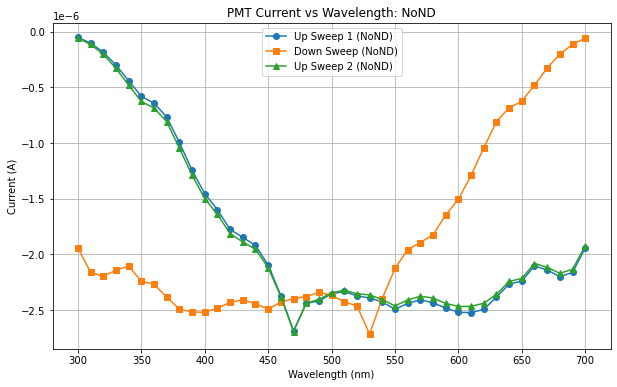

In [8]:
# === CONFIGURATION ===
my_mono = Monochromator()   # initializes with the Calibration directory that is in the current path                                                
my_mono.connect()           # connect to serial port                                                                                                
my_mono.shutter_pos = 0     # 0: closed, 1: open
my_mono.wavelength = 550

filter_name = "NoND"  # change for each filter
notebook_dir = Path().resolve()  # current notebook directory
filename = notebook_dir / "ND_filters.csv"

wavelength = np.arange(300, 701, 10)

# === DATA ACQUISITION ===
current = []
scan_sequence = np.concatenate([wavelength, wavelength[::-1], wavelength])

my_mono.shutter_pos = 1
for wl in scan_sequence:
    my_mono.wavelength = wl
    current.append(np.mean(Picoamp_6485_0.Instance().read(2)))
    print(wl, ": ", current[-1])
my_mono.shutter_pos = 0

# Split currents into sweeps
n_points = len(wavelength)
current_up1 = current[0:n_points]
current_down = current[n_points:2*n_points]
current_up2 = current[2*n_points:3*n_points]

# === CREATE DATAFRAME ===
df_new = pd.DataFrame({
    "Wavelength": wavelength,
    f"Up1_{filter_name}": current_up1,
    f"Down_{filter_name}": current_down,
    f"Up2_{filter_name}": current_up2
})

# === APPEND OR CREATE CSV IN NOTEBOOK FOLDER ===
if filename.exists():
    df_existing = pd.read_csv(filename)
    df_merged = pd.merge(df_existing, df_new, on="Wavelength", how="outer")
else:
    df_merged = df_new

df_merged.to_csv(filename, index=False)
print(f"Data saved to {filename}")



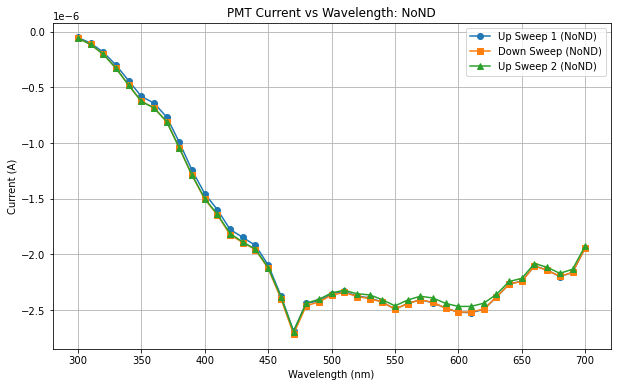

In [9]:
# === OPTIONAL PLOT ===
plt.figure(figsize=(10,6))
plt.plot(wavelength, current_up1, label=f'Up Sweep 1 ({filter_name})', marker='o')
plt.plot(wavelength, current_down[::-1], label=f'Down Sweep ({filter_name})', marker='s')
plt.plot(wavelength, current_up2, label=f'Up Sweep 2 ({filter_name})', marker='^')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Current (A)')
plt.title(f'PMT Current vs Wavelength: {filter_name}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# === PLOT w/ NUMBER OF PHOTONS ===
spectral=np.array(pd.read_csv('nist.csv', skiprows=5, encoding='latin1',delimiter=";")).transpose()
nist_photons=np.interp(wavelength,spectral[0],spectral[1])


In [3]:
#Import data from measurement and remove dark current
wavelength=np.arange(350,651,1) 
nist_no_nd=-np.array([-1.954024e-07, -2.0941635e-07, -2.266921e-07, -2.3987385e-07, -2.5668025e-07, -2.5142275e-07, -2.6336045e-07, -2.769191e-07, -2.9032635e-07, -3.0597405e-07, -3.1873144999999996e-07, -3.324593e-07, -3.463463e-07, -3.5924165e-07, -3.742004e-07, -3.888952e-07, -4.0496325e-07, -4.2165120000000003e-07, -4.3992265e-07, -4.5929535e-07, -4.765969e-07, -5.036491499999999e-07, -5.2709465e-07, -5.5322545e-07, -5.804615500000001e-07, -6.088943000000001e-07, -6.3212545e-07, -6.694945e-07, -6.9533645e-07, -7.274536000000001e-07, -7.661561999999999e-07, -7.9300955e-07, -8.252592e-07, -8.652238499999999e-07, -8.988115999999999e-07, -9.3290995e-07, -9.674252e-07, -9.985823e-07, -1.0413909999999999e-06, -1.070568e-06, -1.115487e-06, -1.152994e-06, -1.1886864999999999e-06, -1.2254345e-06, -1.2586505e-06, -1.289328e-06, -1.3206635e-06, -1.3470824999999998e-06, -1.37061e-06, -1.4033535e-06, -1.4209249999999999e-06, -1.4516915e-06, -1.4771615000000001e-06, -1.5041749999999999e-06, -1.5304709999999998e-06, -1.5563685000000001e-06, -1.5758374999999999e-06, -1.6088775e-06, -1.632905e-06, -1.652177e-06, -1.661849e-06, -1.6835870000000001e-06, -1.715247e-06, -1.7467605e-06, -1.7768875e-06, -1.8095645e-06, -1.8426314999999999e-06, -1.8703449999999999e-06, -1.896856e-06, -1.926489e-06, -1.9544515e-06, -1.9800575000000003e-06, -2.001238e-06, -2.018119e-06, -2.0395575e-06, -2.053679e-06, -2.072305e-06, -2.0936410000000002e-06, -2.111678e-06, -2.134369e-06, -2.1525430000000003e-06, -2.1747735e-06, -2.2013094999999997e-06, -2.220428e-06, -2.2490085e-06, -2.270986e-06, -2.2891555e-06, -2.3069825e-06, -2.3184465e-06, -2.3287789999999997e-06, -2.339733e-06, -2.3536419999999997e-06, -2.3728245e-06, -2.3910995e-06, -2.4202135000000004e-06, -2.4521025e-06, -2.489363e-06, -2.5217565e-06, -2.5727114999999997e-06, -2.6068969999999997e-06, -2.6599555e-06, -2.696403e-06, -2.723407e-06, -2.7599345e-06, -2.7918575e-06, -2.8277375e-06, -2.85295e-06, -2.8968725e-06, -2.942666e-06, -2.9978255e-06, -3.0776309999999998e-06, -3.132621e-06, -3.2189135e-06, -3.2952125000000003e-06, -3.354672e-06, -3.440325e-06, -3.489803e-06, -3.5470305e-06, -3.5905005000000003e-06, -3.5973015e-06, -3.5931560000000002e-06, -3.5825475e-06, -3.5474110000000002e-06, -3.509432e-06, -3.4683399999999997e-06, -3.4281595e-06, -3.397091e-06, -3.377471e-06, -3.367163e-06, -3.363966e-06, -3.363262e-06, -3.3656665e-06, -3.3661285e-06, -3.369483e-06, -3.3718310000000003e-06, -3.371796e-06, -3.378501e-06, -3.388079e-06, -3.396925e-06, -3.4166304999999997e-06, -3.4378679999999997e-06, -3.4563600000000002e-06, -3.4732905e-06, -3.4811874999999998e-06, -3.481475e-06, -3.4790715e-06, -3.4674665000000003e-06, -3.4584835e-06, -3.4477875000000002e-06, -3.4426949999999997e-06, -3.439987e-06, -3.437487e-06, -3.4394065e-06, -3.4424705e-06, -3.4434765e-06, -3.447007e-06, -3.4518179999999998e-06, -3.459915e-06, -3.466492e-06, -3.474536e-06, -3.4851510000000002e-06, -3.495083e-06, -3.508124e-06, -3.5193655000000003e-06, -3.532676e-06, -3.545355e-06, -3.5607645000000003e-06, -3.5743325e-06, -3.5854109999999997e-06, -3.5984125e-06, -3.613018e-06, -3.623499e-06, -3.634804e-06, -3.643284e-06, -3.654775e-06, -3.6594295e-06, -3.6697895e-06, -3.6763230000000003e-06, -3.677978e-06, -3.6848675000000003e-06, -3.693162e-06, -3.6971590000000003e-06, -3.7057690000000004e-06, -3.713956e-06, -3.7251619999999997e-06, -3.7354684999999997e-06, -3.745493e-06, -3.7582440000000002e-06, -3.780625e-06, -3.7993e-06, -3.817698e-06, -3.8355435e-06, -3.8534635e-06, -3.8739764999999996e-06, -3.895172499999999e-06, -3.912647e-06, -3.924682000000001e-06, -3.93891e-06, -3.946532e-06, -3.9542175e-06, -3.9559225e-06, -3.9608035e-06, -3.959952e-06, -3.957510499999999e-06, -3.9529335e-06, -3.947838e-06, -3.938374e-06, -3.929928e-06, -3.924915e-06, -3.9130965e-06, -3.9059510000000005e-06, -3.8948475e-06, -3.890732000000001e-06, -3.8862539999999995e-06, -3.883017e-06, -3.8837845e-06, -3.884036e-06, -3.8822295e-06, -3.8867525e-06, -3.890923999999999e-06, -3.8956195000000005e-06, -3.9082230000000005e-06, -3.911037999999999e-06, -3.917478e-06, -3.925336499999999e-06, -3.9334055e-06, -3.9402465000000005e-06, -3.95312e-06, -3.958237e-06, -3.966219e-06, -3.973639e-06, -3.984607e-06, -3.9910040000000005e-06, -3.9996885e-06, -4.009463e-06, -4.020023e-06, -4.030819000000001e-06, -4.0380225e-06, -4.0511905e-06, -4.063848499999999e-06, -4.0721165e-06, -4.0765365000000005e-06, -4.089899e-06, -4.0980615e-06, -4.108788500000001e-06, -4.121679e-06, -4.128798499999999e-06, -4.1358465e-06, -4.1462205000000005e-06, -4.1540285e-06, -4.1640355e-06, -4.168090500000001e-06, -4.167453e-06, -4.1733375000000004e-06, -4.1750155e-06, -4.177559999999999e-06, -4.1803035e-06, -4.18304e-06, -4.182775e-06, -4.184195e-06, -4.185878e-06, -4.1837395e-06, -4.186807500000001e-06, -4.1871219999999994e-06, -4.1820135e-06, -4.1836375e-06, -4.182815500000001e-06, -4.181136e-06, -4.173549e-06, -4.1626945e-06, -4.1565185000000005e-06, -4.1449785e-06, -4.135645e-06, -4.11736e-06, -4.103281e-06, -4.084555e-06, -4.06754e-06, -4.0468145e-06, -4.030688e-06, -4.010365e-06, -3.9914125e-06, -3.9711375e-06, -3.9472295e-06, -3.9268775e-06, -3.906982e-06, -3.890422e-06, -3.8666960000000005e-06, -3.8516165e-06, -3.834878e-06, -3.821480500000001e-06, -3.8150715e-06, -3.810851e-06, -3.8092695e-06, -3.8094295e-06, -3.811511e-06, -3.8148515e-06, -3.8149305e-06, -3.8128145e-06, -3.806397e-06, -3.798508e-06, -3.782469e-06])
sipm=np.array(pd.read_csv("sipm_QE.csv", header=None))
nist=-np.array(pd.read_csv("nist_QE.csv", header=None))

nist_dk=3.8583867999999996e-14 #2.5162236e-13
sipm_dk=2.493832e-06 #1.7706650000000001e-06


nist-=nist_dk
sipm-=sipm_dk

#Import data from datasheets
nd5_old = np.array(pd.read_csv('ND5_old.csv', header=None)).transpose()                             #transmission of ND filter
nd3=np.array(pd.read_csv('ND3.csv',sep="\t", header=None)).transpose()
nd5=np.array(pd.read_csv('ND5.csv',sep=",", header=None)).transpose()
spectral=np.array(pd.read_csv('nist.csv', skiprows=5, encoding='latin1',delimiter=";")).transpose()    #NIST spectral responsivity
xenon=np.array(pd.read_csv('xenon_lamp_output.csv', header=None)).transpose()                          #Xenon Lamp spectral power distribution
mono=np.array(pd.read_csv('mono.csv',sep=";",decimal=",")).transpose()                                 #Monochromator efficiency
pde_datasheet=np.array(pd.read_csv('PDE_SIPM.csv',sep=";",decimal=",",header=None)).transpose()

pde_comp=np.interp(wavelength,pde_datasheet[0],pde_datasheet[1])
nist_photons=np.interp(wavelength,spectral[0],spectral[1])

<function matplotlib.pyplot.show(close=None, block=None)>

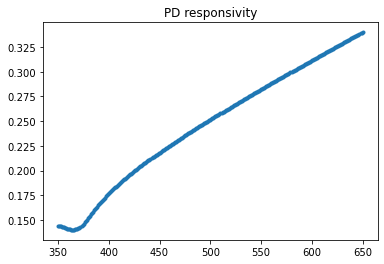

In [ ]:

plt.title("PD responsivity")
plt.plot(wavelength,nist_photons,'.')
plt.show

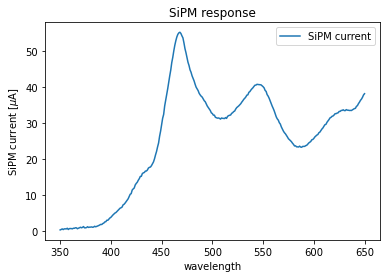

In [6]:
plt.title("SiPM response")
plt.plot(wavelength,sipm*1e6, label="SiPM current") #Current is measured with Pico amp ?
plt.ylabel("SiPM current [$\mu$A]")
plt.xlabel("wavelength")
plt.legend()
plt.show()

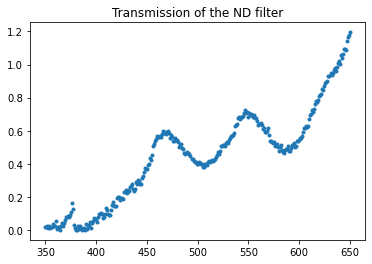

1.2243323436695204


(0.0, 2.5)

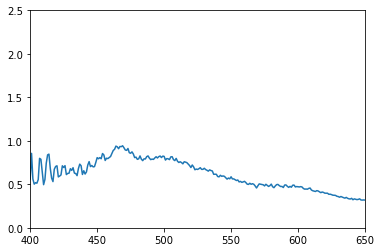

In [41]:
plt.title("Transmission of the ND filter")
plt.plot(nd[0],nd[1]*1000,'.')
convert_transmission=interp1d(nd[0],nd[1]*1000)
plt.show()
plt.plot(wavelength,(sipm*1e4)/convert_transmission(wavelength), label="SiPM current *1e4") #Current is measured with Pico amp ?
plt.xlim(400,650)
plt.ylim(0,2.5)

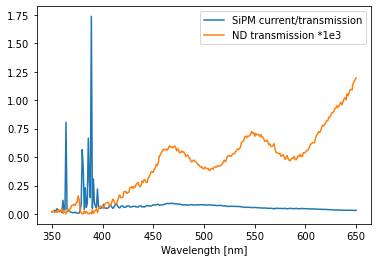

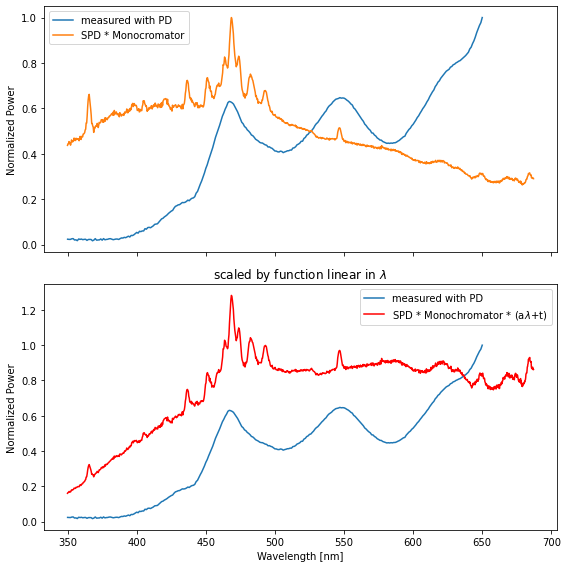

In [26]:
transmission=[]
for wl in wavelength:
    transmission.append(float(nd[1][np.argwhere(nd[0]==wl)][0]))
transmission = np.array(transmission)
sipm/=transmission

#Plot SiPM corrected current
plt.plot(wavelength,sipm,label="SiPM current/transmission")
plt.plot(wavelength,transmission*1e3, label="ND transmission *1e3")
plt.xlabel("Wavelength [nm]")
plt.legend()
plt.show()

#Normalize Nist
max_nist=np.max(nist[0])
nist[0]/=max_nist

#Multiply by monochromator efficiency
mono_interp = np.interp(xenon[0], mono[0], mono[1])
xenon_mono =xenon[1]*mono_interp 
xenon_wl=xenon[1]*mono_interp*(0.17*xenon[0]-55)

#Normalize Xenon Lamp
xenon_mono/=np.max(xenon_mono)
print(np.max(xenon_wl))

#Make Plots
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# First subplot: nist and xenon_scaled
axs[0].set_ylabel("Normalized Power")
axs[0].legend()

# Second subplot: nist and xenon_wl
axs[1].plot(wavelength, nist[0], label="measured with PD")
axs[1].plot(xenon[0], xenon_wl, label="SPD * Monochromator * (a$\\lambda$+t)", color="red")
axs[1].set_xlabel("Wavelength [nm]")
axs[1].set_ylabel("Normalized Power")
axs[1].legend()
axs[1].set_title("scaled by function linear in $\lambda$")

plt.tight_layout()
plt.show()

In [3]:
#sipm1=np.array([4.262345499999999e-06, 4.6516180000000006e-06, 5.57041e-06, 7.918716999999999e-06, 1.216526e-05, 1.7060214999999997e-05, 1.262104e-05, 1.301367e-05, 1.4327754999999999e-05, 1.0646574999999999e-05, 1.0308095e-05, 1.2072365e-05, 1.3196675e-05])
#sipm2=np.array([2.9548345e-06, 3.0021045e-06, 3.8846825e-06, 6.2316435000000004e-06, 1.0186795e-05, 1.498693e-05, 1.136417e-05, 1.190262e-05, 1.3173235e-05, 9.7280765e-06, 9.5665085e-06, 1.1455555e-05, 1.2667185e-05])
#nist3=-np.array([-1.7233965e-07, -2.0941115e-07, -2.6494375e-07, -3.2673965000000003e-07, -4.0845155e-07, -5.309128e-07, -6.8406465e-07, -8.487119e-07, -1.029585e-06, -1.2045550000000001e-06, -1.343252e-06, -1.4787425e-06, -1.6120745e-06, -1.7717635e-06, -1.931394e-06, -2.0392419999999998e-06, -2.152635e-06, -2.276224e-06, -2.35967e-06, -2.4785355e-06, -2.704286e-06, -2.8805305e-06, -3.1564185e-06, -3.5443705e-06, -3.685816e-06, -3.511933e-06, -3.4520015e-06, -3.467859e-06, -3.5410060000000002e-06, -3.585865e-06, -3.5476135e-06, -3.56287e-06, -3.5986365e-06, -3.6661765e-06, -3.732712e-06, -3.7830435e-06, -3.8142934999999998e-06, -3.853056e-06, -3.9408215e-06, -4.043513e-06, -4.0872000000000004e-06, -4.07438e-06, -4.031489e-06, -4.00668e-06, -4.0231225e-06, -4.0570565e-06, -4.0987205e-06, -4.148481000000001e-06, -4.200578999999999e-06, -4.246189999999999e-06, -4.288483e-06, -4.3063644999999995e-06, -4.315166e-06, -4.3201065e-06, -4.292868e-06, -4.214362e-06, -4.1189125e-06, -4.009202e-06, -3.932657499999999e-06, -3.932379e-06, -3.900723500000001e-06])
#nist2=-np.array([-2.0095025000000002e-07, -2.4223585e-07, -3.0311455e-07, -3.692179e-07, -4.593515e-07, -5.873381e-07, -7.3921295e-07, -9.109813999999999e-07, -1.0919255e-06, -1.2716955e-06, -1.406331e-06, -1.5434645e-06, -1.677298e-06, -1.827712e-06, -1.990446e-06, -2.1013974999999997e-06, -2.2058045e-06, -2.327239e-06, -2.4043470000000002e-06, -2.521779e-06, -2.7455564999999998e-06, -2.9211489999999997e-06, -3.183256e-06, -3.5748275000000003e-06, -3.7275329999999997e-06, -3.5516394999999997e-06, -3.49193e-06, -3.505154e-06, -3.5728495e-06, -3.6221905e-06, -3.5813775e-06, -3.5928705e-06, -3.6315239999999997e-06, -3.6939415e-06, -3.768029e-06, -3.8164975e-06, -3.8516345e-06, -3.8940955e-06, -3.9842270000000004e-06, -4.078912e-06, -4.1279415e-06, -4.121346e-06, -4.078533e-06, -4.053756e-06, -4.067037e-06, -4.1076825e-06, -4.1513459999999995e-06, -4.1986425e-06, -4.2518905e-06, -4.2475275e-06, -4.2905835e-06, -4.307741e-06, -4.3104695e-06, -4.315009e-06, -4.2871785e-06, -4.213685e-06, -4.1186380000000005e-06, -4.009414e-06, -3.932748e-06, -3.9294405e-06, -3.8932e-06])
#sipm=np.array([2.3830085e-06, 2.4331980000000002e-06, 2.3229535e-06, 2.3739384999999997e-06, 2.543739e-06, 2.4822544999999996e-06, 2.706063e-06, 2.8681645000000003e-06, 3.082887e-06, 3.940956499999999e-06, 5.2517615e-06, 6.531747e-06, 7.710482000000001e-06, 9.690480500000001e-06, 1.217229e-05, 1.5219195e-05, 1.757364e-05, 1.8836265e-05, 2.0642850000000002e-05, 2.4789685e-05, 3.2575665000000005e-05, 4.20765e-05, 5.1629954999999996e-05, 5.937102e-05, 5.950107e-05, 5.2604345000000004e-05, 4.7096595e-05, 4.3441355e-05, 4.081301e-05, 3.8766675e-05, 3.6006365e-05, 3.481356e-05, 3.4709255e-05, 3.522339e-05, 3.638996e-05, 3.8119259999999997e-05, 4.0114235e-05, 4.1979955000000005e-05, 4.4311240000000006e-05, 4.508489e-05, 4.406563e-05, 4.13628e-05, 3.7689945e-05, 3.4177305e-05, 3.129489e-05, 2.8757409999999997e-05, 2.682225e-05, 2.5895385000000002e-05, 2.5993705000000002e-05, 2.676893e-05, 2.8312675e-05, 2.9914669999999998e-05, 3.1877045e-05, 3.387651e-05, 3.5636700000000004e-05, 3.6280625e-05, 3.650526e-05, 3.6694824999999995e-05, 3.7209774999999996e-05, 3.906397e-05, 4.1540624999999995e-05])


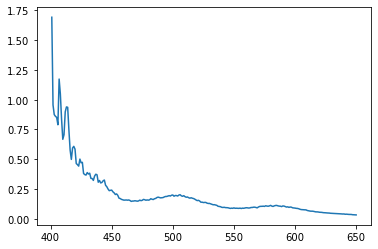

In [27]:
ratio=sipm/nist[0]

mask = wavelength > 400
wavelength_filtered = wavelength[mask]
ratio_filtered=ratio[mask]

plt.plot(wavelength_filtered,ratio_filtered)
plt.show()

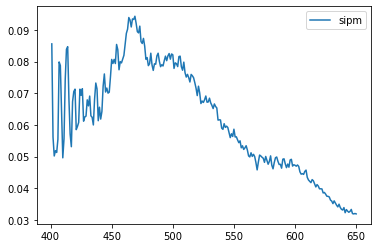

In [5]:
#SiPM plot

# Filter for wavelengths > 400 nm
mask = wavelength > 400
wavelength_filtered = wavelength[mask]
sipm_filtered = sipm[mask]
transmission_filtered = np.array(transmission)[mask]

# SiPM plot for wavelengths > 400 nm
plt.plot(wavelength_filtered, sipm_filtered, label="sipm")

plt.legend()
plt.show()

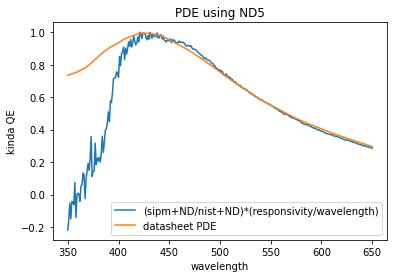

In [5]:
# (SIPM + ND _filter / NIST+ND_filter)*NIST_responsivity=PDE of the SIPM 
pde_sipm=sipm[0]/nist[0]*nist_photons/wavelength
pde_sipm/=np.max(pde_sipm)
plt.plot(wavelength,pde_sipm,label="(sipm+ND/nist+ND)*(responsivity/wavelength)")
plt.plot(wavelength,pde_comp/50,label="datasheet PDE")
plt.title("PDE using ND5")
plt.ylabel("kinda QE")
plt.xlabel("wavelength")
plt.legend()
plt.show()

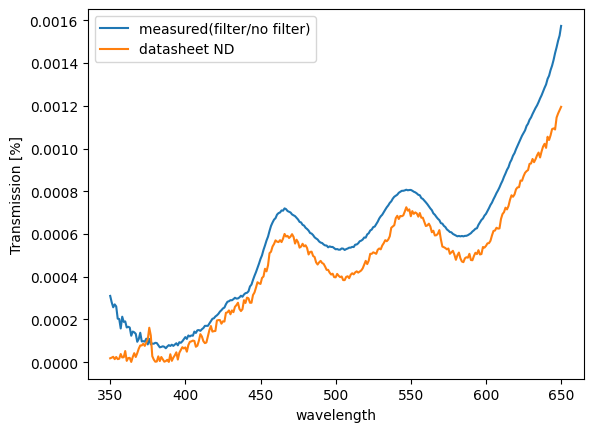

In [5]:
transm_nd=nist[0]/nist_no_nd*100
plt.plot(wavelength,transm_nd,label="measured(filter/no filter)")
plt.plot(nd5_old[0],nd5_old[1],label="datasheet ND")
plt.ylabel("Transmission [%]")
plt.xlabel("wavelength")
plt.legend()
plt.show()

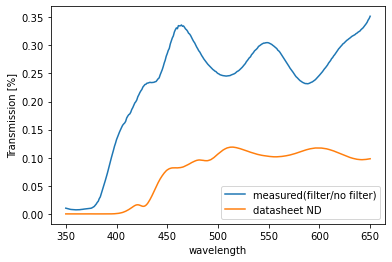

In [51]:
transm_nd=nist[2]/nist_no_nd*50
plt.plot(wavelength,transm_nd,label="measured(filter/no filter)")
plt.plot(nd3[0],nd3[1],label="datasheet ND")
plt.ylabel("Transmission [%]")
plt.xlabel("wavelength")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


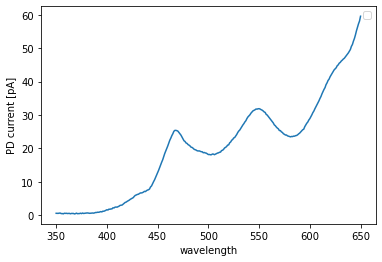

In [21]:
plt.plot(wavelength,nist[0]*1e12)
plt.ylabel("PD current [pA]")
plt.xlabel("wavelength")
plt.legend()
plt.show()

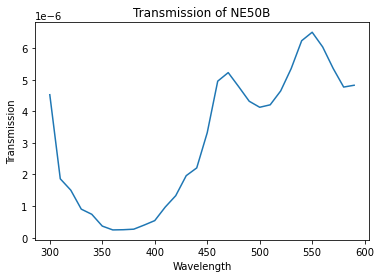

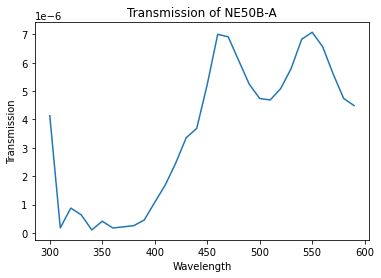

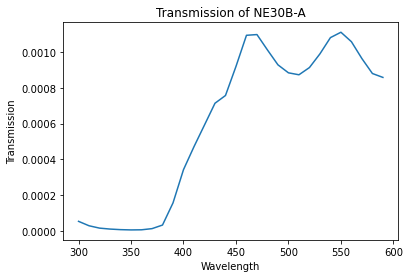

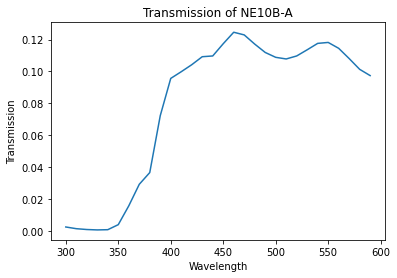

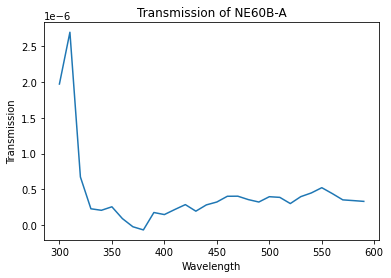

In [13]:
#ND-Filter Validation
filters=["ND5_old","ND5","ND3","ND1","ND6"]
names=["NE50B","NE50B-A","NE30B-A","NE10B-A","NE60B-A",] 
sep=[",","\t",",",","] 
wavelength=np.arange(300,600,10)
data=-np.array(pd.read_csv("ND_filter_test.csv",header=None))
darkrate=8.456024e-14
data-=darkrate
for i in range(len(filters)):
    ratio=data[i+1]/data[0]
    plt.plot(wavelength,ratio,label="measured transmission")
    #ref=np.array(pd.read_csv(f'{filters[i]}.csv',sep=sep[i], header=None)).transpose()
    #plt.plot(wavelength,np.interp(wavelength,ref[0],ref[1])*0.01,label=f"datasheet {names[i]}-A")
    #ref2=np.array(pd.read_csv(f'{filters[i]}_old.csv',sep=",", header=None)).transpose()
    #plt.plot(wavelength,np.interp(wavelength,ref2[0],ref2[1])*0.01,label=f"datasheet {names[i]}")
    #plt.legend()
    plt.title(f"Transmission of {names[i]}")
    plt.xlabel("Wavelength")
    plt.ylabel("Transmission")
    plt.show()

In [16]:
import numpy as np

wl_new = np.arange(300, 595, 5)

for i in range(len(filters)):
    ratio = data[i+1] / data[0]
    ratio_interp = np.interp(wl_new, wavelength, ratio)
    
    idx_365 = np.where(wl_new == 365)[0][0]
    idx_405 = np.where(wl_new == 405)[0][0]
    
    print(
        names[i],
        ": 365nm:", ratio_interp[idx_365],
        ", 405nm:", ratio_interp[idx_405]
    )


NE50B : 365nm: 2.4906136050739644e-07 , 405nm: 7.550222235388347e-07
NE50B-A : 365nm: 1.933601606508918e-07 , 405nm: 1.38341337088224e-06
NE30B-A : 365nm: 9.86861770063262e-06 , 405nm: 0.0004065477860186529
NE10B-A : 365nm: 0.022382418201162987 , 405nm: 0.0977324318225147
NE60B-A : 365nm: 3.409895143639383e-08 , 405nm: 1.828796478513719e-07
